In [1]:
import somadata
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv
import numpy as np
import os
from io import StringIO
print("Done")

Done


In [37]:
from scipy.stats import ttest_ind
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from io import StringIO
print('done')

done


In [38]:
#Path to this directory
dirpath = os.path.abspath(os.path.dirname('SAHData.ipynb'))

In [39]:
#adat file that has been plate scaled and hybrid normalized (not median normalized)
adat_path = dirpath + '/Data/UFL-17-005DataFromSoma-Jenna-SerumConbine/UFL-17-005.hybNorm.plateScale.20180411.adat'
adat = somadata.read_adat(adat_path)
type(adat)

/Users/kenny/opt/anaconda3/lib/python3.9/site-packages/somadata/io/adat/file.py:125: UserWarning: V3 style seqIds (i.e., 12345-6_7). Converting to V4 Style. The adat file writer has an option to write using the V3 style
  warnings.warn(


somadata.adat.Adat

In [40]:
adat.columns

MultiIndex([(  '10336-3', '3', 'SL019100', ...),
            ( '10337-83', '3', 'SL007136', ...),
            ( '10339-48', '3', 'SL001731', ...),
            ( '10342-55', '3', 'SL019096', ...),
            ('10344-334', '3', 'SL005173', ...),
            (  '10346-5', '3', 'SL007221', ...),
            ( '10351-51', '3', 'SL007108', ...),
            ( '10356-21', '3', 'SL000455', ...),
            ( '10358-33', '3', 'SL003755', ...),
            ( '10361-25', '3', 'SL014684', ...),
            ...
            (   '9199-6', '3', 'SL018946', ...),
            (  '9201-13', '3', 'SL004811', ...),
            ( '9202-309', '3', 'SL008113', ...),
            (  '9204-33', '3', 'SL009210', ...),
            (  '9207-60', '3', 'SL018887', ...),
            (  '9211-19', '3', 'SL003066', ...),
            (  '9212-22', '3', 'SL008381', ...),
            (  '9213-24', '3', 'SL018900', ...),
            ( '9215-117', '3', 'SL018947', ...),
            ( '9216-100', '3', 'SL009948', ...)],
   

In [54]:
#Loading in the a CSV. Will need to change path on personal computer
csv_path = dirpath + '/Data/NumbersOnly_vasospasm_identifiers_072224.csv'
df = pd.read_csv(csv_path)
vaso_list = df.iloc[:, 0].tolist()
print(vaso_list)

['1', 'EXCLUDE', '??????Exclude?????? - need to compare, see notes', 'Pilot Control ', 'EXCLUDE', '1', '0', '0', 'EXCLUDE', 'EXCLUDE', '1', 'Pilot Control ', 'EXCLUDE', 'BB Control', '1', '1', '1', 'BB Control', '0', '1', 'EXCLUDE', '1', '0', '0', 'EXCLUDE', 'BB Control', '1', '1', 'EXCLUDE', '0', 'Pilot Control ', '1', '1', '0', '1', '1', '0', '0', '1', 'Pilot Control ', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '0', '0', '0', 'Pilot Control ', '0', '0', '0', 'Pilot Control ', '1', '1', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0']


In [55]:
#Merging vasospasm data with SAH adat file. Source code derived from Soma Logic Canopy GitHub

vaso_adat = adat.insert_meta(0,'Vasospasm (0=n, 1=y)', vaso_list)
# this will produce a new Adat file with group data in the right most column of the index

vaso_adat.index.to_frame(index=False).loc[0:1]

,PlateId,ScannerID,PlatePosition,SlideId,Subarray,SampleId,SampleType,PercentDilution,SampleMatrix,Barcode,...,AssayNotes,TimePoint,ExtIdentifier,SsfExtId,SampleGroup,SiteId,TubeUniqueID,HybControlNormScale,RowCheck,"Vasospasm (0=n, 1=y)"
0,Set 003,US83800208,H4,257711020969,8,160384,QC,40,QC,160384C,...,QC,,EXID40000001310062,2577110209698,,,,1.125,PASS,1
1,Set 003,US83800208,H3,257711020968,8,PHE-L Dichot,Sample,40,,,...,PHE-L Dichot,,EXID40000001310064,EID323094,,,,0.997,PASS,EXCLUDE


In [56]:
#Displaying adat file. Source code derived from Soma Logic Canopy GitHub

from IPython.display import HTML
#Display the first five rows and columns of the adat
HTML(vaso_adat.iloc[:160, :10].to_html())

,,,,,,,,,,,,,,,,,,,,,,SeqId,10336-3,10337-83,10339-48,10342-55,10344-334,10346-5,10351-51,10356-21,10358-33,10361-25
,,,,,,,,,,,,,,,,,,,,,,SeqIdVersion,3,3,3,3,3,3,3,3,3,3
,,,,,,,,,,,,,,,,,,,,,,SomaId,SL019100,SL007136,SL001731,SL019096,SL005173,SL007221,SL007108,SL000455,SL003755,SL014684
,,,,,,,,,,,,,,,,,,,,,,TargetFullName,E3 ubiquitin-protein ligase CHIP,CCAAT/enhancer-binding protein beta,Gamma-enolase,E3 SUMO-protein ligase PIAS4,Interleukin-10 receptor subunit alpha,Signal transducer and activator of transcription 3,Interferon regulatory factor 1,Transcription factor AP-1,Induced myeloid leukemia cell differentiation protein Mcl-1,2'-5'-oligoadenylate synthase 1
,,,,,,,,,,,,,,,,,,,,,,Target,CHIP,CEBPB,NSE,PIAS4,IL-10 Ra,STAT3,IRF1,c-Jun,Mcl-1,OAS1
,,,,,,,,,,,,,,,,,,,,,,UniProt,Q9UNE7,P17676,P09104,Q8N2W9,Q13651,P40763,P10914,P05412,Q07820,P00973
,,,,,,,,,,,,,,,,,,,,,,EntrezGeneID,10273,1051,2026,51588,3587,6774,3659,3725,4170,4938
,,,,,,,,,,,,,,,,,,,,,,EntrezGeneSymbol,STUB1,CEBPB,ENO2,PIAS4,IL10RA,STAT3,IRF1,JUN,MCL1,OAS1
,,,,,,,,,,,,,,,,,,,,,,Organism,Human,Human,Human,Human,Human,Human,Human,Human,Human,Human
,,,,,,,,,,,,,,,,,,,,,,Units,RFU,RFU,RFU,RFU,RFU,RFU,RFU,RFU,RFU,RFU
,,,,,,,,,,,,,,,,,,,,,,Type,Protein,Protein,Protein,Protein,Protein,Protein,Protein,Protein,Protein,Protein


In [57]:
#Check to see number of patients vs controls/calibrators
Counter(vaso_adat.index.get_level_values('SampleType'))

Counter({'QC': 9, 'Sample': 72, 'Calibrator': 15})

In [58]:
filtered_transformed_data = (
    vaso_adat
        .exclude_on_meta(axis=0, name='SampleMatrix', values=['Calibrator', 'QC'])                     
        .pick_on_meta(axis=0, name='Vasospasm (0=n, 1=y)', values=['0', '1'])  # rm control samples
        .apply(np.log10)                                             # log10-transform
)

In [59]:
clean_data = (
    filtered_transformed_data
        .insert_keyed_meta(                                          
            axis=0,
            key_meta_name='Vasospasm (0=n, 1=y)',
            inserted_meta_name='Vaso',
            values_dict={'1': 1, '0': 0}
        )
        .apply(lambda x: x - x.mean(), axis=0)                       # center features
        .apply(lambda x: x / x.std(), axis=0)                        # scale features
)


In [60]:
print(clean_data.index.to_frame()['Vaso'].value_counts())

0    31
1    23
Name: Vaso, dtype: int64


In [61]:
tt_g0 = clean_data.pick_on_meta(axis=0, name='Vaso', values=[0])
tt_g1 = clean_data.pick_on_meta(axis=0, name='Vaso', values=[1])

tt_res = ttest_ind(tt_g0, tt_g1)
t_tests = list(zip(clean_data.columns.get_level_values('TargetFullName'), tt_res.pvalue))

In [62]:
t_tests_sorted = sorted(t_tests, key=lambda x: x[1])
tt_top_12_analytes = [name for name, p_value in t_tests_sorted[:12]]
tt_top_12_analytes
print("p values of top 12: ", t_tests_sorted[:12])

p values of top 12:  [('Fibronectin', 0.0004375189498753765), ('Immunoglobulin G', 0.0011302195284374772), ('Leukotriene A-4 hydrolase', 0.0013425392201824077), ('Muellerian-inhibiting factor', 0.001667375333571172), ('Coagulation Factor V', 0.001787799249032596), ('Fibronectin Fragment 3', 0.0020118907555962936), ('E3 ubiquitin-protein ligase CHIP', 0.002095667616847062), ('Histone H3.1', 0.0023340790405606835), ('Histone H2B type 2-E', 0.003397745662033758), ('Xaa-Pro aminopeptidase 1', 0.0035285949109660326), ('Connective tissue-activating peptide III', 0.0039398921371795225), ('Fibronectin Fragment 4', 0.004006201737303732)]


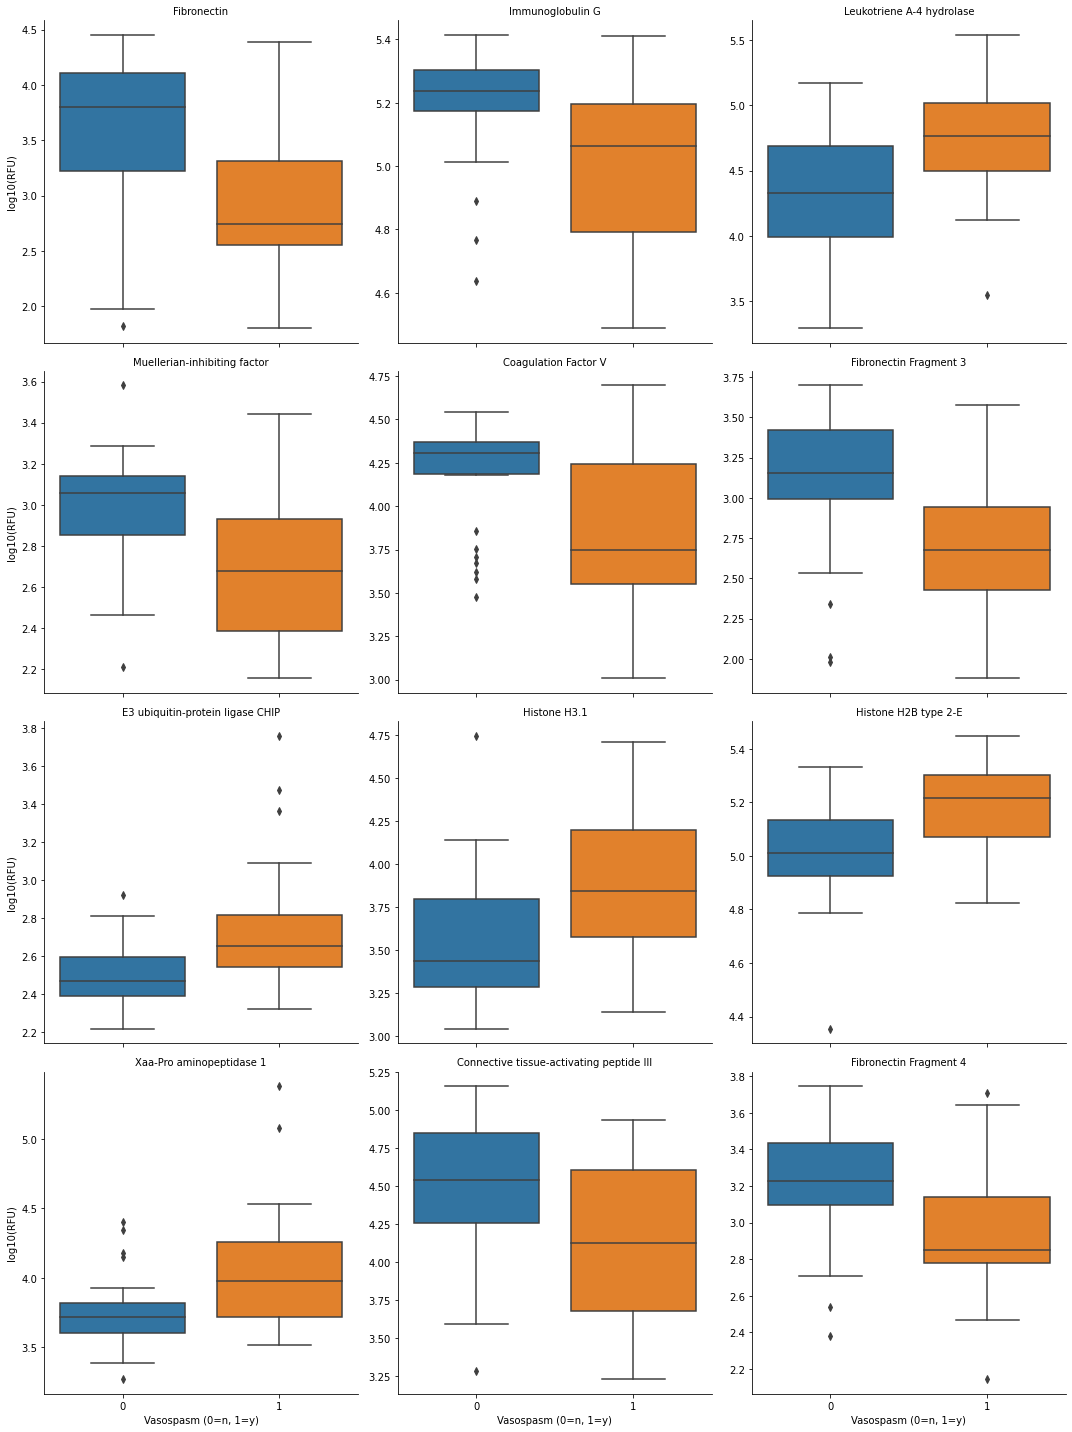

In [63]:
tt_df= (
    filtered_transformed_data
        .pick_meta(axis=1, names=['TargetFullName'])
        .pick_on_meta(axis=1, name='TargetFullName', values=tt_top_12_analytes)[tt_top_12_analytes]
        .reset_index()
)

tt_melted_df = pd.melt(tt_df, value_vars=tt_top_12_analytes, id_vars='Vasospasm (0=n, 1=y)', value_name='log10(RFU)')

tt_p = sns.catplot(
    x='Vasospasm (0=n, 1=y)',
    y='log10(RFU)',
    col='TargetFullName',
    data=tt_melted_df,
    kind='box',
    col_wrap=3,
    sharey=False
)
tt_p.set_titles(row_template='{row_name}', col_template='{col_name}')
plt.show()

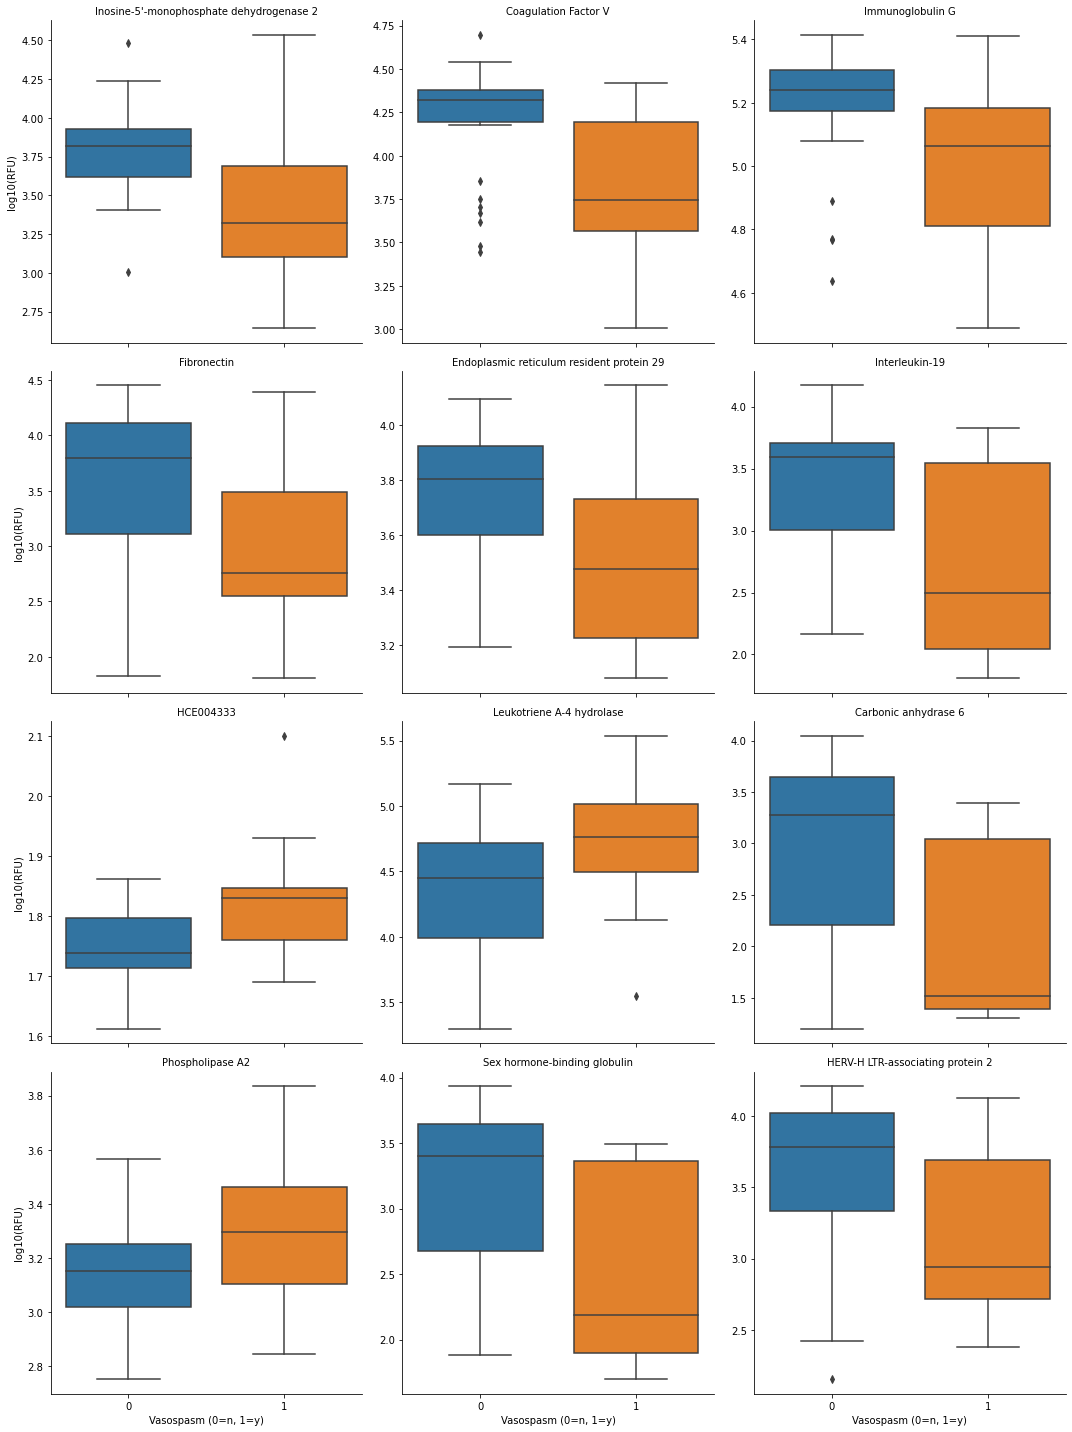

In [49]:
tt_df= (
    filtered_transformed_data
        .pick_meta(axis=1, names=['TargetFullName'])
        .pick_on_meta(axis=1, name='TargetFullName', values=tt_top_12_analytes)[tt_top_12_analytes]
        .reset_index()
)

tt_melted_df = pd.melt(tt_df, value_vars=tt_top_12_analytes, id_vars='Vasospasm (0=n, 1=y)', value_name='log10(RFU)')

tt_p = sns.catplot(
    x='Vasospasm (0=n, 1=y)',
    y='log10(RFU)',
    col='TargetFullName',
    data=tt_melted_df,
    kind='box',
    col_wrap=3,
    sharey=False
)
tt_p.set_titles(row_template='{row_name}', col_template='{col_name}')
plt.show()

In [50]:
print(tt_df.columns)

Index(['PlateId', 'ScannerID', 'PlatePosition', 'SlideId', 'Subarray',
       'SampleId', 'SampleType', 'PercentDilution', 'SampleMatrix', 'Barcode',
       'Barcode2d', 'SampleNotes', 'SampleDescription', 'AssayNotes',
       'TimePoint', 'ExtIdentifier', 'SsfExtId', 'SampleGroup', 'SiteId',
       'TubeUniqueID', 'HybControlNormScale', 'RowCheck',
       'Vasospasm (0=n, 1=y)', 'Inosine-5'-monophosphate dehydrogenase 2',
       'Coagulation Factor V', 'Immunoglobulin G', 'Fibronectin',
       'Endoplasmic reticulum resident protein 29', 'Interleukin-19',
       'HCE004333', 'Leukotriene A-4 hydrolase', 'Carbonic anhydrase 6',
       'Phospholipase A2', 'Sex hormone-binding globulin',
       'HERV-H LTR-associating protein 2'],
      dtype='object', name='TargetFullName')


In [ ]:
# One-sample t-tests
p_values = []
for protein in patient_data.columns:
    stat, p_value = ttest_1samp(patient_data[protein], reference_medians[protein])
    p_values.append(p_value)

In [96]:
#Plate scale that has been plate scaled, hybrid normalized, and median normalized (used for QC)
adat2 = somadata.read_adat('/Users/kenny/Documents/Medical School/Research/MSSRP/Data/UFL-17-005DataFromSoma-Jenna-SerumConbine/UFL-17-005.hybNorm.plateScale.medNorm.20180411.adat')

#Display the first ten rows and columns of the adat
HTML(adat2.iloc[:10, :10].to_html())

/Users/kenny/opt/anaconda3/lib/python3.9/site-packages/somadata/io/adat/file.py:125: UserWarning: V3 style seqIds (i.e., 12345-6_7). Converting to V4 Style. The adat file writer has an option to write using the V3 style
  warnings.warn(


,,,,,,,,,,,,,,,,,,,,,,,,SeqId,10336-3,10337-83,10339-48,10342-55,10344-334,10346-5,10351-51,10356-21,10358-33,10361-25
,,,,,,,,,,,,,,,,,,,,,,,,SeqIdVersion,3,3,3,3,3,3,3,3,3,3
,,,,,,,,,,,,,,,,,,,,,,,,SomaId,SL019100,SL007136,SL001731,SL019096,SL005173,SL007221,SL007108,SL000455,SL003755,SL014684
,,,,,,,,,,,,,,,,,,,,,,,,TargetFullName,E3 ubiquitin-protein ligase CHIP,CCAAT/enhancer-binding protein beta,Gamma-enolase,E3 SUMO-protein ligase PIAS4,Interleukin-10 receptor subunit alpha,Signal transducer and activator of transcription 3,Interferon regulatory factor 1,Transcription factor AP-1,Induced myeloid leukemia cell differentiation protein Mcl-1,2'-5'-oligoadenylate synthase 1
,,,,,,,,,,,,,,,,,,,,,,,,Target,CHIP,CEBPB,NSE,PIAS4,IL-10 Ra,STAT3,IRF1,c-Jun,Mcl-1,OAS1
,,,,,,,,,,,,,,,,,,,,,,,,UniProt,Q9UNE7,P17676,P09104,Q8N2W9,Q13651,P40763,P10914,P05412,Q07820,P00973
,,,,,,,,,,,,,,,,,,,,,,,,EntrezGeneID,10273,1051,2026,51588,3587,6774,3659,3725,4170,4938
,,,,,,,,,,,,,,,,,,,,,,,,EntrezGeneSymbol,STUB1,CEBPB,ENO2,PIAS4,IL10RA,STAT3,IRF1,JUN,MCL1,OAS1
,,,,,,,,,,,,,,,,,,,,,,,,Organism,Human,Human,Human,Human,Human,Human,Human,Human,Human,Human
,,,,,,,,,,,,,,,,,,,,,,,,Units,RFU,RFU,RFU,RFU,RFU,RFU,RFU,RFU,RFU,RFU
,,,,,,,,,,,,,,,,,,,,,,,,Type,Protein,Protein,Protein,Protein,Protein,Protein,Protein,Protein,Protein,Protein
